**Packages**

In [2]:
import numpy as np
import pandas as pd
import math
import seaborn as sn

import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import concatenate
import tensorflow_addons as tfa
import tifffile

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import os

import scipy

2023-03-25 05:57:15.560698: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-25 05:57:17.393839: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-25 05:57:17.393875: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-25 05:57:21.606951: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

**Helper Functions**

In [3]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
   # plt.plot(history.history['accuracy'], label='accuracy')
   # plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.ylim([0, 
            max(
                max(history.history['loss']),
                max(history.history['val_loss'])
            )])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()
    plt.grid(True)

In [4]:
def plot_accuracy(history):
   # plt.plot(history.history['loss'], label='loss')
   # plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.ylim([0, 
            max(
                max(history.history['accuracy']),
                max(history.history['val_accuracy'])
            )])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.grid(True)

In [5]:
def plot_f1(history):
    plt.plot(history.history['f1'], label='train_f1')
    plt.plot(history.history['val_f1'], label='val_f1')
    plt.ylim([0, 
            max(
                max(history.history['f1']),
                max(history.history['val_f1'])
            )])
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('F1 Score')
    plt.legend()
    plt.grid(True)

In [6]:
# FROM https://github.com/jimmyyhwu/resnet18-tf2/blob/master/resnet.py

kaiming_normal = keras.initializers.VarianceScaling(scale=2.0, mode='fan_out', distribution='untruncated_normal')

def conv3x3(x, out_planes, stride=1, name=None):
    x = layers.ZeroPadding2D(padding=1, name=f'{name}_pad')(x)
    return layers.Conv2D(filters=out_planes, kernel_size=3, strides=stride, use_bias=False, kernel_initializer=kaiming_normal, name=name)(x)

def basic_block(x, planes, stride=1, downsample=None, name=None):
    identity = x

    out = conv3x3(x, planes, stride=stride, name=f'{name}.conv1')
    out = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.bn1')(out)
    out = layers.ReLU(name=f'{name}.relu1')(out)

    out = conv3x3(out, planes, name=f'{name}.conv2')
    out = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.bn2')(out)

    if downsample is not None:
        for layer in downsample:
            identity = layer(identity)

    out = layers.Add(name=f'{name}.add')([identity, out])
    out = layers.ReLU(name=f'{name}.relu2')(out)

    return out

def make_layer(x, planes, blocks, stride=1, name=None):
    downsample = None
    inplanes = x.shape[3]
    if stride != 1 or inplanes != planes:
        downsample = [
            layers.Conv2D(filters=planes, kernel_size=1, strides=stride, use_bias=False, kernel_initializer=kaiming_normal, name=f'{name}.0.downsample.0'),
            layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.0.downsample.1'),
        ]

    x = basic_block(x, planes, stride, downsample, name=f'{name}.0')
    for i in range(1, blocks):
        x = basic_block(x, planes, name=f'{name}.{i}')

    return x

def resnet(x, blocks_per_layer, num_classes=1000):
    x = layers.ZeroPadding2D(padding=3, name='conv1_pad')(x)
    x = layers.Conv2D(filters=64, kernel_size=7, strides=2, use_bias=False, kernel_initializer=kaiming_normal, name='conv1')(x)
    x = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name='bn1')(x)
    x = layers.ReLU(name='relu1')(x)
    x = layers.ZeroPadding2D(padding=1, name='maxpool_pad')(x)
    x = layers.MaxPool2D(pool_size=3, strides=2, name='maxpool')(x)

    x1 = make_layer(x, 64, blocks_per_layer[0], name='layer1')
    x2 = make_layer(x1, 128, blocks_per_layer[1], stride=2, name='layer2')
    x3 = make_layer(x2, 256, blocks_per_layer[2], stride=2, name='layer3')
    x4 = make_layer(x3, 512, blocks_per_layer[3], stride=2, name='layer4')

    x = layers.GlobalAveragePooling2D(name='avgpool')(x4)
    initializer = keras.initializers.RandomUniform(-1.0 / math.sqrt(512), 1.0 / math.sqrt(512))
    x = layers.Dense(units=num_classes, kernel_initializer=initializer, bias_initializer=initializer, name='fc')(x)

    return x1, x2, x3, x4

def resnet18(x, **kwargs):
    return resnet(x, [2, 2, 2, 2], **kwargs)

def resnet34(x, **kwargs):
    return resnet(x, [3, 4, 6, 3], **kwargs)

**Data Pre-Processing**

Pulling in Train and Test Sets

In [7]:
tiles_train = pd.read_csv(r'./Data/Tiles_TRAIN.csv')
#x_train = tiles_train.drop(['bins_numeric'], axis = 1)
#y_train = tiles_train['bins_numeric']
#x_train.head(5)

In [8]:
x_train, x_val, y_train, y_val = train_test_split(tiles_train.drop(['bins_numeric'], axis = 1), tiles_train['bins_numeric'],
                                   random_state=104, 
                                   test_size=0.20, 
                                   shuffle=True)
x_train.head(5)

,Tile_ID,Stop_Signs,Paving_historical,Bus_stop,Collisions_Historical,RTTYP_I,RTTYP_M,RTTYP_O,RTTYP_S,RTTYP_U,...,94129,94130,94131,94132,94133,94134,94141,94143,94158,94188
1762,1526,0.0,0.0,0.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4603,11426,0.0,7.0,0.0,8.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6484,13993,0.0,0.0,0.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6950,3201,0.0,0.0,0.0,0.0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4254,13779,0.0,0.0,0.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
x_val.head(5)

,Tile_ID,Stop_Signs,Paving_historical,Bus_stop,Collisions_Historical,RTTYP_I,RTTYP_M,RTTYP_O,RTTYP_S,RTTYP_U,...,94129,94130,94131,94132,94133,94134,94141,94143,94158,94188
2732,2948,0.0,0.0,0.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
630,2945,4.0,0.0,2.0,1.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2887,7123,1.0,0.0,0.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
752,12171,0.0,0.0,2.0,1.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8106,1096,2.0,0.0,0.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
tiles_test = pd.read_csv(r'./Data/Tiles_TEST.csv')
x_test = tiles_test.drop(['Tile_ID','bins_numeric'], axis = 1)
y_test = tiles_test['bins_numeric']
x_test.head(5)

,Stop_Signs,Paving_historical,Bus_stop,Collisions_Historical,RTTYP_I,RTTYP_M,RTTYP_O,RTTYP_S,RTTYP_U,94101,...,94129,94130,94131,94132,94133,94134,94141,94143,94158,94188
0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,1.0,0.0,3.0,6.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,0.0,0.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.0,0.0,0.0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0.0,0.0,0.0,0.0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


Image Pre-Processing

In [11]:
# TRAIN SET 

IMAGE_PATH = './Satellite Imagery/Satellite Images Tiled/' 

def preprocess_data_part1(IMAGE_PATH):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 149 3)
    """
    
    data_mini = []
    
    for id in x_train['Tile_ID']:    
                    
        # read image and store as matrix            
        # Index at the end makes all images the same size (they sometimes differ by 1 pixel)
        image = tifffile.imread(IMAGE_PATH + str(id) + '.tif')[0:148, 0:188, :]
            
        # append to images
        data_mini.append(image)
 
    # stack images and trasnform to array
    images_mini = np.stack(data_mini)
    
    return images_mini

In [12]:
images_mini = preprocess_data_part1(IMAGE_PATH)
np.shape(images_mini)

(6700, 148, 188, 4)

In [13]:
x_train = x_train.drop(['Tile_ID'], axis = 1)

In [14]:
# VAL SET 

IMAGE_PATH = './Satellite Imagery/Satellite Images Tiled/' 

def preprocess_data_part15(IMAGE_PATH):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 149 3)
    """
    
    data_mini = []
    
    for id in x_val['Tile_ID']:    
                    
        # read image and store as matrix            
        # Index at the end makes all images the same size (they sometimes differ by 1 pixel)
        image = tifffile.imread(IMAGE_PATH + str(id) + '.tif')[0:148, 0:188, :]
            
        # append to images
        data_mini.append(image)
 
    # stack images and trasnform to array
    images_mini = np.stack(data_mini)
    
    return images_mini

In [15]:
images_mini_v = preprocess_data_part15(IMAGE_PATH)
np.shape(images_mini_v)

(1676, 148, 188, 4)

In [16]:
x_val = x_val.drop(['Tile_ID'], axis = 1)

In [17]:
# TEST SET

IMAGE_PATH = './Satellite Imagery/Satellite Images Tiled/' 

def preprocess_data_part2(IMAGE_PATH):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 149 3)
    """
    
    data_mini = []
    
    for id in tiles_test['Tile_ID']:    
                    
        # read image and store as matrix            
        # Index at the end makes all images the same size (they sometimes differ by 1 pixel)
        image = tifffile.imread(IMAGE_PATH + str(id) + '.tif')[0:148, 0:188, :]
            
        # append to images
        data_mini.append(image)
 
    # stack images and trasnform to array
    images_mini = np.stack(data_mini)
    
    return images_mini

In [18]:
images_mini_t = preprocess_data_part2(IMAGE_PATH)
np.shape(images_mini_t)

(2095, 148, 188, 4)

Street Data Pre-Processing

In [19]:
# TRAIN SET 

street = np.asarray(x_train).astype('float32')
street_mini = []
for row in range(len(street)):
    street_mini.append([[street[row]]])
street_mini = np.stack(street_mini)
np.shape(street_mini)

(6700, 1, 1, 39)

In [20]:
# VAL SET 

street_v = np.asarray(x_val).astype('float32')
street_mini_v = []
for row in range(len(street_v)):
    street_mini_v.append([[street_v[row]]])
street_mini_v = np.stack(street_mini_v)
np.shape(street_mini_v)

(1676, 1, 1, 39)

In [21]:
# TEST SET 

street_t = np.asarray(x_test).astype('float32')
street_mini_t = []
for row in range(len(street_t)):
    street_mini_t.append([[street_t[row]]])
street_mini_t = np.stack(street_mini_t)
np.shape(street_mini_t)

(2095, 1, 1, 39)

**Modeling**

Helpful Links: <br>
https://pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/ <br>
https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50 <br>
https://github.com/jimmyyhwu/resnet18-tf2/blob/master/resnet.py <BR>

**Model 2.4.0: Baseline (Best From Stage 3)**

In [118]:
# From previous experiments, adding layers and using ResNet-18 yielded best results 

# x: Satellite Images, 'Stop_Signs', 'Paving_historical', 'Bus_stop', 'Collisions_Historical', Road type (one hot), Zipcode (ont hot)
# y: Future collision bin

# ACCORDING TO THE PAPER, THEY DOWNSIZED THE IMAGES FIRST INTO SMALLER MATRICES 
# THEN ADDED THE STREET CHARACTERISTICS TO THE SMALLER MATRIX
# REFERENCE THE DIAGRAM ON THE PAPER

def create_cnn_model():

    # INPUT LAYERS
    input1 = tf.keras.layers.Input(shape=(148, 188, 4), name='Input_Images')
    input2 = tf.keras.layers.Input(shape=(1,1,39), name='Input_Street') 
    
    #CNN FOR IMAGE PROCESSING
    cnn = tf.keras.layers.Conv2D(39, (2,2), activation="relu")(input1) # layers = street data dimension
    pooling = tf.keras.layers.MaxPooling2D((2, 2), strides=1)(cnn)
    images = tf.keras.models.Model(inputs=input1, outputs=pooling)
    
    #ADDING STREET DATA
    #combined = tf.keras.layers.Concatenate(axis = 2)([images.output, input2])
    combined = tf.keras.layers.Add()([images.output, input2])
    
    # PAPER USES RESNET-18 FOR THE REST OF THE MODEL WITH THE COMBINED DATA
    resnet = resnet18(combined)
    output = tf.keras.layers.Dense(units=11, activation='softmax', name='output')(resnet) # units = number of classes
    
    #instantiation layer 
    cnn_model = tf.keras.models.Model(inputs=[input1, input2], outputs=output)
    
    return cnn_model

cnn_model = create_cnn_model()

cnn_model.summary()

f1 = tfa.metrics.F1Score(
    num_classes = 11,
    average = 'macro',
    threshold = None,
    name = 'f1',
    )

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics = ['accuracy', f1])

class_weight = {0: 1,
                1: 10,
                2: 10,
                3: 10,
                4: 10,
                5: 10,
                6: 10,
                7: 10,
                8: 10,
                9: 10,
                10: 10,
                # 11: 10,
               }

y_t = tf.keras.utils.to_categorical(y_train, num_classes=11)

y_v = tf.keras.utils.to_categorical(y_val, num_classes=11)

cnn_model.layers[-1].bias.assign([0,0,0,0,0,0,0,0,0,0,0]) # no bias

history = cnn_model.fit(
    [images_mini, street_mini],
    y_t,
    epochs=10,
    # Suppress logging.
     verbose=1,
    validation_data=([images_mini_v, street_mini_v], y_v),
    # Calculate validation results on 20% of the training data.
    #validation_split = 0.2,
    class_weight = class_weight
    )

Model: "model_29"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Images (InputLayer)      [(None, 148, 188, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_14 (Conv2D)             (None, 147, 187, 39  663         ['Input_Images[0][0]']           
                                )                                                                 
                                                                                                  
 max_pooling2d_14 (MaxPooling2D  (None, 146, 186, 39  0          ['conv2d_14[0][0]']              
 )                              )                                                          

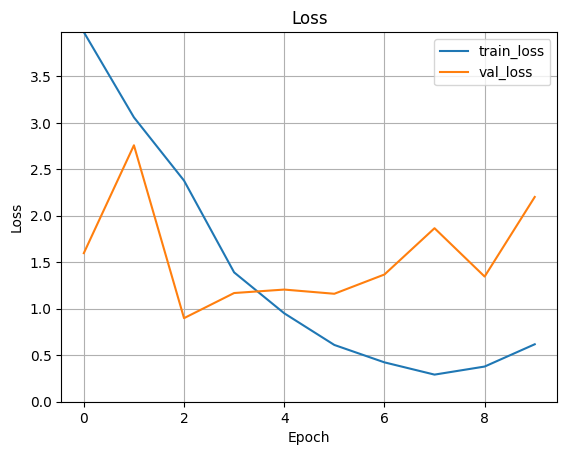

In [119]:
plot_loss(history)

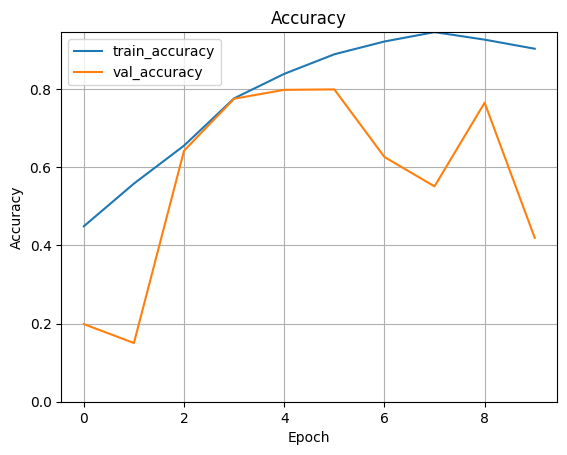

In [120]:
plot_accuracy(history)

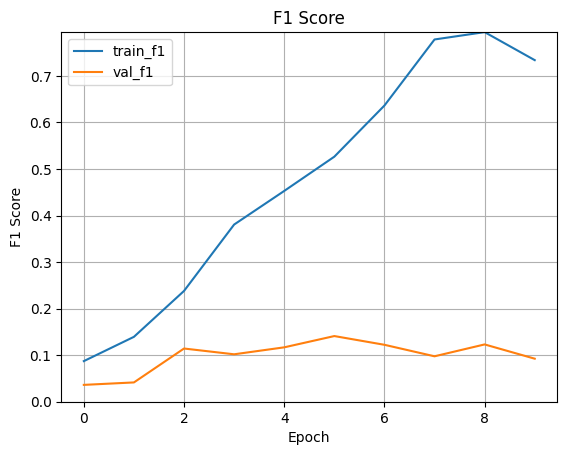

In [121]:
plot_f1(history)

In [122]:
y_pred = cnn_model.predict([images_mini_v, street_mini_v])
y_pred

53/53 [==============================] - 20s 378ms/step


array([[1.2071420e-01, 1.0935767e-02, 6.9000787e-01, ..., 2.4507958e-02,
        6.6884612e-03, 8.4629375e-03],
       [5.9842765e-03, 2.1688294e-02, 8.1416899e-01, ..., 9.5434915e-03,
        9.5403921e-03, 5.4168818e-03],
       [3.5612080e-03, 2.8518859e-02, 5.5902833e-01, ..., 2.9126827e-02,
        1.6398121e-02, 1.4603347e-02],
       ...,
       [1.0110101e-02, 8.9767254e-06, 3.4251270e-01, ..., 3.1339682e-03,
        1.0897957e-03, 1.2662798e-03],
       [9.1607414e-02, 2.1236525e-04, 1.6790575e-01, ..., 1.6286539e-02,
        1.5407834e-02, 7.0894081e-03],
       [3.8177487e-02, 5.5767912e-03, 8.0643177e-01, ..., 2.6520014e-02,
        8.2131866e-03, 9.2127174e-03]], dtype=float32)

In [123]:
pred_values = []
for i in y_pred: 
    input_list = i
    max_value = max(input_list)
    index = [index for index, item in enumerate(input_list) if item == max_value]
    pred_values.append(index[0])
pred_values[0:5]

[2, 2, 2, 1, 4]

In [124]:
y_true = list(y_val)
y_true[0:5]

[0, 0, 0, 0, 0]

In [128]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, pred_values)
df_cm = pd.DataFrame(cm, index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"])
df_cm

,0,1,2,3,4,5,6,7,8,9
0,568,22,571,43,20,4,68,51,0,0
1,0,0,7,2,1,3,6,6,0,1
2,38,2,125,10,5,6,29,18,0,0
3,2,0,29,6,2,6,4,4,0,0
4,0,0,0,0,0,1,1,1,0,1
5,0,0,0,0,0,0,1,0,0,0
6,0,0,3,0,0,1,3,1,0,0
7,0,0,0,0,0,0,2,1,0,0
8,0,0,0,0,0,0,1,0,0,0
9,0,0,0,0,0,0,0,0,0,0


In [129]:
# saving initial weights to be used in other models
import tempfile
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
cnn_model.save_weights(initial_weights)

**Model 2.4.1: Initial Bias Corrected**

In [130]:
check = pd.DataFrame({'bins': y_train, 'ones': np.ones(len(y_train))}, columns=['bins', 'ones'])
pivot = check.pivot_table(index=['bins'], values=['ones'], aggfunc=len)
print(pivot)

      ones
bins      
0     5297
1      108
2      968
3      230
4       22
5        4
6       53
7       11
8        3
9        1
10       3


In [131]:
initial_bias = []
for i in range(len(pivot['ones'])):
    b = np.log(pivot['ones'][i] / (sum(pivot['ones'][:i]) + sum(pivot['ones'][i + 1:])))
    initial_bias.append(b)
initial_bias

[1.3285278214420657,
 -4.111480844465088,
 -1.7785877016714855,
 -3.336852078571751,
 -5.715531367145284,
 -7.422971251049421,
 -4.8316289904894605,
 -6.410324392320038,
 -7.710802655241941,
 -8.809713540508268,
 -7.710802655241941]

In [132]:
# From previous experiments, adding layers and using ResNet-18 yielded best results 

# x: Satellite Images, 'Stop_Signs', 'Paving_historical', 'Bus_stop', 'Collisions_Historical', Road type (one hot), Zipcode (ont hot)
# y: Future collision bin

# ACCORDING TO THE PAPER, THEY DOWNSIZED THE IMAGES FIRST INTO SMALLER MATRICES 
# THEN ADDED THE STREET CHARACTERISTICS TO THE SMALLER MATRIX
# REFERENCE THE DIAGRAM ON THE PAPER

def create_cnn_model1(output_bias = None):

    # INPUT LAYERS
    input1 = tf.keras.layers.Input(shape=(148, 188, 4), name='Input_Images')
    input2 = tf.keras.layers.Input(shape=(1,1,39), name='Input_Street') 
    
    #CNN FOR IMAGE PROCESSING
    cnn = tf.keras.layers.Conv2D(39, (2,2), activation="relu")(input1) # layers = street data dimension
    pooling = tf.keras.layers.MaxPooling2D((2, 2), strides=1)(cnn)
    images = tf.keras.models.Model(inputs=input1, outputs=pooling)
    
    #ADDING STREET DATA
    #combined = tf.keras.layers.Concatenate(axis = 2)([images.output, input2])
    combined = tf.keras.layers.Add()([images.output, input2])
    
    # PAPER USES RESNET-18 FOR THE REST OF THE MODEL WITH THE COMBINED DATA
    resnet = resnet18(combined)
    
    if output_bias is not None:
        # initial bias added
        output_bias = tf.keras.initializers.Constant(output_bias)    
        output = tf.keras.layers.Dense(units=11, activation='softmax', name='output', bias_initializer=output_bias)(resnet) # units = number of classes
    else: 
        output = tf.keras.layers.Dense(units=11, activation='softmax', name='output')(resnet) # units = number of classes
        
    #instantiation layer 
    cnn_model = tf.keras.models.Model(inputs=[input1, input2], outputs=output)
    
    return cnn_model

# initial bias added
cnn_model1 = create_cnn_model1(output_bias = initial_bias)

cnn_model1.summary()

f1 = tfa.metrics.F1Score(
    num_classes = 11,
    average = 'macro',
    threshold = None,
    name = 'f1',
    )

cnn_model1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics = ['accuracy', f1])

class_weight = {0: 1,
                1: 10,
                2: 10,
                3: 10,
                4: 10,
                5: 10,
                6: 10,
                7: 10,
                8: 10,
                9: 10,
                10: 10,
                # 11: 10,
               }

y_t = tf.keras.utils.to_categorical(y_train, num_classes=11)

y_v = tf.keras.utils.to_categorical(y_val, num_classes=11)

cnn_model1.load_weights(initial_weights) # initial weights from first model to make it comparable

history = cnn_model1.fit(
    [images_mini, street_mini],
    y_t,
    epochs=10,
    # Suppress logging.
     verbose=1,
    validation_data=([images_mini_v, street_mini_v], y_v),
    # Calculate validation results on 20% of the training data.
    #validation_split = 0.2,
    class_weight = class_weight
    )

/home/ubuntu/capstone/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer VarianceScaling is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "model_31"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Images (InputLayer)      [(None, 148, 188, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 147, 187, 39  663         ['Input_Images[0][0]']           
                                )                                                                 
                                                                                                  
 max_pooling2d_15 (MaxPooling2D  (None, 146, 186, 39  0          ['conv2d_15[0][0]']              
 )                              )                                                          

/home/ubuntu/capstone/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


                                                                                                  
 layer2.1.add (Add)             (None, 19, 24, 128)  0           ['layer2.0.relu2[0][0]',         
                                                                  'layer2.1.bn2[0][0]']           
                                                                                                  
 layer2.1.relu2 (ReLU)          (None, 19, 24, 128)  0           ['layer2.1.add[0][0]']           
                                                                                                  
 layer3.0.conv1_pad (ZeroPaddin  (None, 21, 26, 128)  0          ['layer2.1.relu2[0][0]']         
 g2D)                                                                                             
                                                                                                  
 layer3.0.conv1 (Conv2D)        (None, 10, 12, 256)  294912      ['layer3.0.conv1_pad[0][0]']     
          

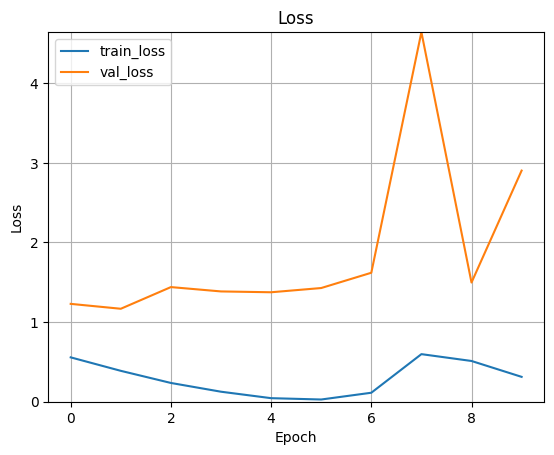

In [133]:
plot_loss(history)

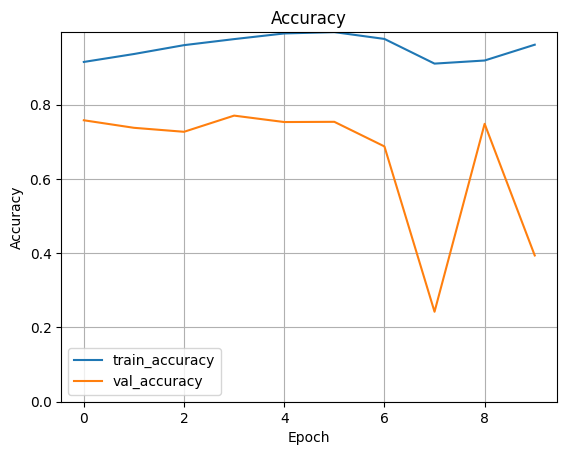

In [134]:
plot_accuracy(history)

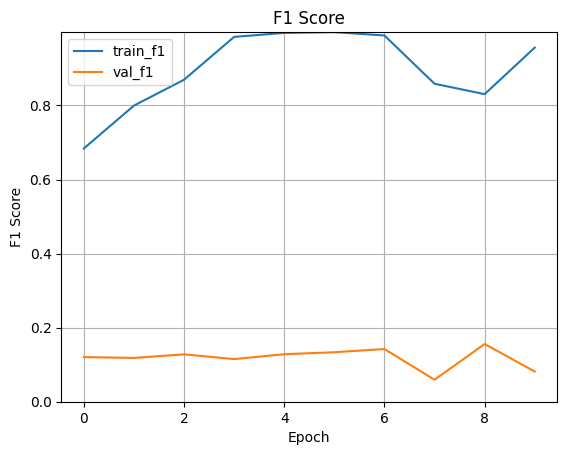

In [135]:
plot_f1(history)

In [136]:
y_pred = cnn_model.predict([images_mini_v, street_mini_v])
y_pred

53/53 [==============================] - 112s 2s/step


array([[1.2071420e-01, 1.0935767e-02, 6.9000787e-01, ..., 2.4507958e-02,
        6.6884612e-03, 8.4629375e-03],
       [5.9842765e-03, 2.1688294e-02, 8.1416899e-01, ..., 9.5434915e-03,
        9.5403921e-03, 5.4168818e-03],
       [3.5612080e-03, 2.8518859e-02, 5.5902833e-01, ..., 2.9126827e-02,
        1.6398121e-02, 1.4603347e-02],
       ...,
       [1.0110101e-02, 8.9767254e-06, 3.4251270e-01, ..., 3.1339682e-03,
        1.0897957e-03, 1.2662798e-03],
       [9.1607414e-02, 2.1236525e-04, 1.6790575e-01, ..., 1.6286539e-02,
        1.5407834e-02, 7.0894081e-03],
       [3.8177487e-02, 5.5767912e-03, 8.0643177e-01, ..., 2.6520014e-02,
        8.2131866e-03, 9.2127174e-03]], dtype=float32)

In [137]:
pred_values1 = []
for i in y_pred: 
    input_list = i
    max_value = max(input_list)
    index = [index for index, item in enumerate(input_list) if item == max_value]
    pred_values1.append(index[0])
pred_values1[0:5]

[2, 2, 2, 1, 4]

In [138]:
y_true = list(y_val)
y_true[0:5]

[0, 0, 0, 0, 0]

In [139]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, pred_values1)
df_cm = pd.DataFrame(cm, index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"])
df_cm
#plt.figure(figsize = (10,7))
#sn.heatmap(df_cm, annot=True)

,0,1,2,3,4,5,6,7,8,9
0,568,22,571,43,20,4,68,51,0,0
1,0,0,7,2,1,3,6,6,0,1
2,38,2,125,10,5,6,29,18,0,0
3,2,0,29,6,2,6,4,4,0,0
4,0,0,0,0,0,1,1,1,0,1
5,0,0,0,0,0,0,1,0,0,0
6,0,0,3,0,0,1,3,1,0,0
7,0,0,0,0,0,0,2,1,0,0
8,0,0,0,0,0,0,1,0,0,0
9,0,0,0,0,0,0,0,0,0,0


**Model 2.4.2: Class Weights Corrected**

In [21]:
check = pd.DataFrame({'bins': y_train, 'ones': np.ones(len(y_train))}, columns=['bins', 'ones'])
pivot = check.pivot_table(index=['bins'], values=['ones'], aggfunc=len)
print(pivot)

      ones
bins      
0     5297
1      108
2      968
3      230
4       22
5        4
6       53
7       11
8        3
9        1
10       3


In [22]:
from sklearn.utils import class_weight 
class_weights = class_weight.compute_class_weight('balanced',classes = np.unique(y_train),y = y_train)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.11498790052688486,
 1: 5.63973063973064,
 2: 0.6292261457550714,
 3: 2.6482213438735176,
 4: 27.68595041322314,
 5: 152.27272727272728,
 6: 11.492281303602057,
 7: 55.37190082644628,
 8: 203.03030303030303,
 9: 609.0909090909091,
 10: 203.03030303030303}

In [25]:
# From previous experiments, adding layers and using ResNet-18 yielded best results 

# x: Satellite Images, 'Stop_Signs', 'Paving_historical', 'Bus_stop', 'Collisions_Historical', Road type (one hot), Zipcode (ont hot)
# y: Future collision bin

# ACCORDING TO THE PAPER, THEY DOWNSIZED THE IMAGES FIRST INTO SMALLER MATRICES 
# THEN ADDED THE STREET CHARACTERISTICS TO THE SMALLER MATRIX
# REFERENCE THE DIAGRAM ON THE PAPER

def create_cnn_model():

    # INPUT LAYERS
    input1 = tf.keras.layers.Input(shape=(148, 188, 4), name='Input_Images')
    input2 = tf.keras.layers.Input(shape=(1,1,39), name='Input_Street') 
    
    #CNN FOR IMAGE PROCESSING
    cnn = tf.keras.layers.Conv2D(39, (2,2), activation="relu")(input1) # layers = street data dimension
    pooling = tf.keras.layers.MaxPooling2D((2, 2), strides=1)(cnn)
    images = tf.keras.models.Model(inputs=input1, outputs=pooling)
    
    #ADDING STREET DATA
    #combined = tf.keras.layers.Concatenate(axis = 2)([images.output, input2])
    combined = tf.keras.layers.Add()([images.output, input2])
    
    # PAPER USES RESNET-18 FOR THE REST OF THE MODEL WITH THE COMBINED DATA
    resnet = resnet18(combined)
    output = tf.keras.layers.Dense(units=11, activation='softmax', name='output')(resnet) # units = number of classes
    
    #instantiation layer 
    cnn_model = tf.keras.models.Model(inputs=[input1, input2], outputs=output)
    
    return cnn_model

cnn_model1 = create_cnn_model()

cnn_model1.summary()

f1 = tfa.metrics.F1Score(
    num_classes = 11,
    average = 'macro',
    threshold = None,
    name = 'f1',
    )

cnn_model1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics = ['accuracy', f1])

# calculated in previous block 
# class_weight = {0: 1,
#                 1: 10,
#                 2: 10,
#                 3: 10,
#                 4: 10,
#                 5: 10,
#                 6: 10,
#                 7: 10,
#                 8: 10,
#                 9: 10,
#                 10: 10,
#                 # 11: 10,
#                }

y_t = tf.keras.utils.to_categorical(y_train, num_classes=11)

y_v = tf.keras.utils.to_categorical(y_val, num_classes=11)

#cnn_model1.load_weights(initial_weights) # initial weights from first or baseline model to make it comparable
cnn_model1.layers[-1].bias.assign([0,0,0,0,0,0,0,0,0,0,0]) # no bias, makes it more comparable to baseline model

history = cnn_model1.fit(
    [images_mini, street_mini],
    y_t,
    epochs=10,
    # Suppress logging.
     verbose=1,
    validation_data=([images_mini_v, street_mini_v], y_v),
    # Calculate validation results on 20% of the training data.
    #validation_split = 0.2,
    class_weight = class_weights
    )

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Images (InputLayer)      [(None, 148, 188, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 147, 187, 39  663         ['Input_Images[0][0]']           
                                )                                                                 
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 146, 186, 39  0          ['conv2d_2[0][0]']               
                                )                                                           

2023-03-24 15:16:14.496981: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2982732800 exceeds 10% of free system memory.


Epoch 1/10
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
210/210 [==============================] - 1433s 7s/step - loss: 3.4852 - accuracy: 0.1479 - f1: 0.0405 - val_loss: 1.8481 - val_accuracy: 0.4624 - val_f1: 0.0863
Epoch 2/10
210/210 [==============================] - 1764s 8s/step - loss: 2.8510 - accuracy: 0.2607 - f1: 0.0663 - val_loss: 1.7730 - val_accuracy: 0.3735 - val_f1: 0.0763
Epoch 3/10
210/210 [==============================] - 1751s 8s/step - loss: 2.3207 - accuracy: 0.3467 - f1: 0.1101 - val_loss: 2.2347 - val_accuracy: 0.3288 - val_f1: 0.0595
Epoch 4/10
210/210 [==============================] - 1782s 8s/step - loss: 1.5361 - accuracy: 0.4212 - f1: 0.1068 - val_loss: 1.6683 - val_accuracy: 0.4397 - val_f1: 0.0787
Epoch 5/10
210/210 [==============================] - 1751s 8s/step - loss: 1.3556 - accuracy: 0.5078 -

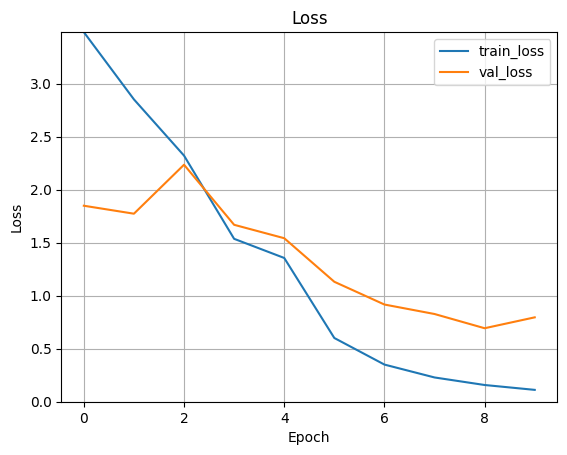

In [26]:
plot_loss(history)

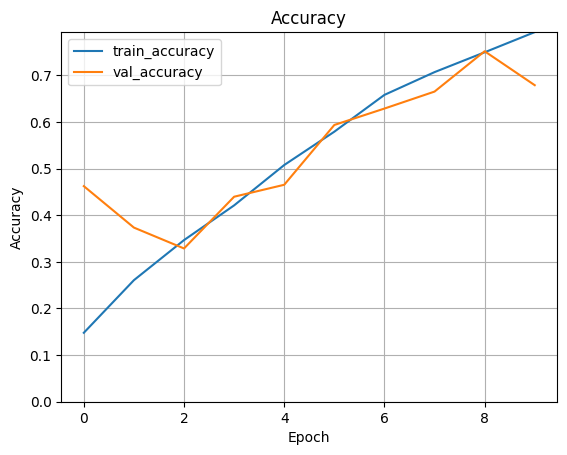

In [27]:
plot_accuracy(history)

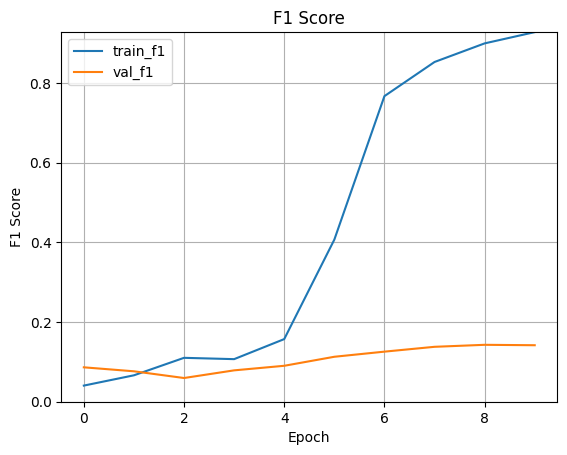

In [28]:
plot_f1(history)

In [29]:
y_pred2 = cnn_model1.predict([images_mini_v, street_mini_v])
y_pred2

53/53 [==============================] - 47s 863ms/step


array([[9.1262615e-01, 4.4900426e-06, 8.7285146e-02, ..., 3.5526796e-07,
        2.3570346e-06, 1.6713345e-07],
       [5.7188904e-01, 3.7081265e-03, 4.0078083e-01, ..., 2.0667991e-04,
        3.0558393e-05, 2.1034688e-05],
       [4.0973309e-01, 4.8469345e-05, 5.3984696e-01, ..., 3.2293025e-05,
        3.2563362e-06, 6.3411511e-07],
       ...,
       [4.6493310e-01, 7.7585160e-04, 5.1365387e-01, ..., 1.7885925e-06,
        2.3357809e-06, 4.0761811e-06],
       [2.6918149e-01, 2.0356894e-02, 3.1847146e-01, ..., 1.6898025e-03,
        4.6587007e-05, 5.2748225e-04],
       [3.7761369e-01, 1.1555870e-04, 6.2099057e-01, ..., 4.2108215e-05,
        2.1966287e-05, 4.3928804e-08]], dtype=float32)

In [30]:
pred_values2 = []
for i in y_pred2: 
    input_list = i
    max_value = max(input_list)
    index = [index for index, item in enumerate(input_list) if item == max_value]
    pred_values2.append(index[0])
pred_values2[0:5]

[0, 0, 2, 3, 2]

In [31]:
y_true = list(y_val)
y_true[0:5]

[0, 0, 0, 0, 0]

In [34]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, pred_values2)
ind = max(len(np.unique(y_true)), len(np.unique(pred_values2)))
df_cm = pd.DataFrame(cm, index = [i for i in range(ind)],
                  columns = [i for i in range(ind)])
df_cm
#plt.figure(figsize = (10,7))
#sn.heatmap(df_cm, annot=True)

,0,1,2,3,4,5,6,7,8
0,1006,2,305,31,0,0,3,0,0
1,2,7,9,7,0,0,1,0,0
2,78,8,115,30,0,0,2,0,0
3,8,5,29,10,1,0,0,0,0
4,0,2,0,2,0,0,0,0,0
5,0,0,0,1,0,0,0,0,0
6,0,1,2,5,0,0,0,0,0
7,0,2,1,0,0,0,0,0,0
8,0,1,0,0,0,0,0,0,0


**Model 2.4.3: Initial Bias and Class Weights Corrected**

In [36]:
initial_bias = []
for i in range(len(pivot['ones'])):
    b = np.log(pivot['ones'][i] / (sum(pivot['ones'][:i]) + sum(pivot['ones'][i + 1:])))
    initial_bias.append(b)
initial_bias

[1.3285278214420657,
 -4.111480844465088,
 -1.7785877016714855,
 -3.336852078571751,
 -5.715531367145284,
 -7.422971251049421,
 -4.8316289904894605,
 -6.410324392320038,
 -7.710802655241941,
 -8.809713540508268,
 -7.710802655241941]

In [37]:
from sklearn.utils import class_weight 
class_weights = class_weight.compute_class_weight('balanced',classes = np.unique(y_train),y = y_train)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.11498790052688486,
 1: 5.63973063973064,
 2: 0.6292261457550714,
 3: 2.6482213438735176,
 4: 27.68595041322314,
 5: 152.27272727272728,
 6: 11.492281303602057,
 7: 55.37190082644628,
 8: 203.03030303030303,
 9: 609.0909090909091,
 10: 203.03030303030303}

In [38]:
# From previous experiments, adding layers and using ResNet-18 yielded best results 

# x: Satellite Images, 'Stop_Signs', 'Paving_historical', 'Bus_stop', 'Collisions_Historical', Road type (one hot), Zipcode (ont hot)
# y: Future collision bin

# ACCORDING TO THE PAPER, THEY DOWNSIZED THE IMAGES FIRST INTO SMALLER MATRICES 
# THEN ADDED THE STREET CHARACTERISTICS TO THE SMALLER MATRIX
# REFERENCE THE DIAGRAM ON THE PAPER

def create_cnn_model3(output_bias = None):

    # INPUT LAYERS
    input1 = tf.keras.layers.Input(shape=(148, 188, 4), name='Input_Images')
    input2 = tf.keras.layers.Input(shape=(1,1,39), name='Input_Street') 
    
    #CNN FOR IMAGE PROCESSING
    cnn = tf.keras.layers.Conv2D(39, (2,2), activation="relu")(input1) # layers = street data dimension
    pooling = tf.keras.layers.MaxPooling2D((2, 2), strides=1)(cnn)
    images = tf.keras.models.Model(inputs=input1, outputs=pooling)
    
    #ADDING STREET DATA
    #combined = tf.keras.layers.Concatenate(axis = 2)([images.output, input2])
    combined = tf.keras.layers.Add()([images.output, input2])
    
    # PAPER USES RESNET-18 FOR THE REST OF THE MODEL WITH THE COMBINED DATA
    resnet = resnet18(combined)
    
    if output_bias is not None:
        # initial bias added
        output_bias = tf.keras.initializers.Constant(output_bias)    
        output = tf.keras.layers.Dense(units=11, activation='softmax', name='output', bias_initializer=output_bias)(resnet) # units = number of classes
    else: 
        output = tf.keras.layers.Dense(units=11, activation='softmax', name='output')(resnet) # units = number of classes
        
    #instantiation layer 
    cnn_model = tf.keras.models.Model(inputs=[input1, input2], outputs=output)
    
    return cnn_model

# initial bias added
cnn_model3 = create_cnn_model3(output_bias = initial_bias)

cnn_model3.summary()

f1 = tfa.metrics.F1Score(
    num_classes = 11,
    average = 'macro',
    threshold = None,
    name = 'f1',
    )

cnn_model3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics = ['accuracy', f1])

# class_weight = {0: 1,
#                 1: 10,
#                 2: 10,
#                 3: 10,
#                 4: 10,
#                 5: 10,
#                 6: 10,
#                 7: 10,
#                 8: 10,
#                 9: 10,
#                 10: 10,
#                 # 11: 10,
#                }

y_t = tf.keras.utils.to_categorical(y_train, num_classes=11)

y_v = tf.keras.utils.to_categorical(y_val, num_classes=11)

#cnn_model1.load_weights(initial_weights) # initial weights from first model to make it comparable

history = cnn_model3.fit(
    [images_mini, street_mini],
    y_t,
    epochs=10,
    # Suppress logging.
     verbose=1,
    validation_data=([images_mini_v, street_mini_v], y_v),
    # Calculate validation results on 20% of the training data.
    #validation_split = 0.2,
    class_weight = class_weights
    )

/home/ubuntu/capstone/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer VarianceScaling is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Images (InputLayer)      [(None, 148, 188, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 147, 187, 39  663         ['Input_Images[0][0]']           
                                )                                                                 
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 146, 186, 39  0          ['conv2d_3[0][0]']               
                                )                                                           

/home/ubuntu/capstone/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


 layer4.1.relu2 (ReLU)          (None, 5, 6, 512)    0           ['layer4.1.add[0][0]']           
                                                                                                  
 avgpool (GlobalAveragePooling2  (None, 512)         0           ['layer4.1.relu2[0][0]']         
 D)                                                                                               
                                                                                                  
 fc (Dense)                     (None, 1000)         513000      ['avgpool[0][0]']                
                                                                                                  
 output (Dense)                 (None, 11)           11011       ['fc[0][0]']                     
                                                                                                  
Total params: 11,823,682
Trainable params: 11,814,082
Non-trainable params: 9,600
___________________________

2023-03-24 20:36:48.292903: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2982732800 exceeds 10% of free system memory.


210/210 [==============================] - 531s 2s/step - loss: 4.3219 - accuracy: 0.2736 - f1: 0.0654 - val_loss: 1.5876 - val_accuracy: 0.4045 - val_f1: 0.0615
Epoch 2/10
210/210 [==============================] - 1773s 8s/step - loss: 2.3250 - accuracy: 0.4004 - f1: 0.0914 - val_loss: 3.3868 - val_accuracy: 0.1420 - val_f1: 0.0272
Epoch 3/10
210/210 [==============================] - 1835s 9s/step - loss: 1.8774 - accuracy: 0.4072 - f1: 0.1089 - val_loss: 1.5000 - val_accuracy: 0.3628 - val_f1: 0.0827
Epoch 4/10
210/210 [==============================] - 1760s 8s/step - loss: 2.1390 - accuracy: 0.3619 - f1: 0.1041 - val_loss: 3.2444 - val_accuracy: 0.2458 - val_f1: 0.0508
Epoch 5/10
210/210 [==============================] - 1798s 9s/step - loss: 2.8832 - accuracy: 0.3125 - f1: 0.0842 - val_loss: 1.7349 - val_accuracy: 0.4081 - val_f1: 0.0863
Epoch 6/10
210/210 [==============================] - 1757s 8s/step - loss: 2.4726 - accuracy: 0.2949 - f1: 0.0794 - val_loss: 1.8616 - val_ac

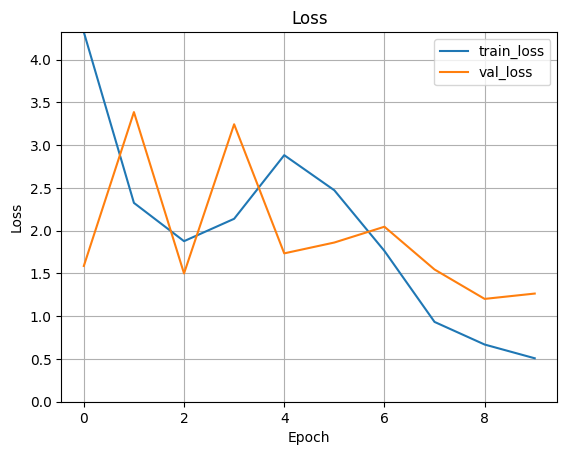

In [39]:
plot_loss(history)

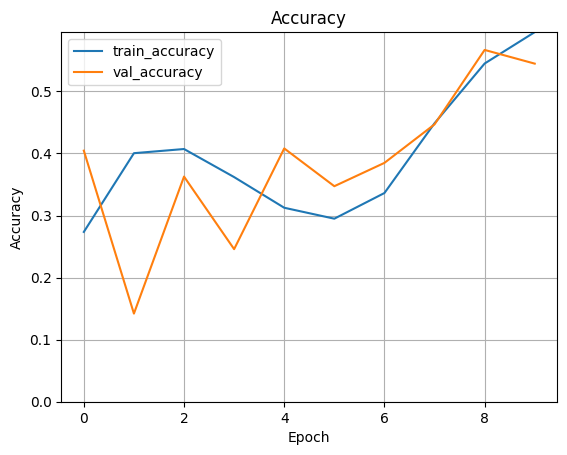

In [40]:
plot_accuracy(history)

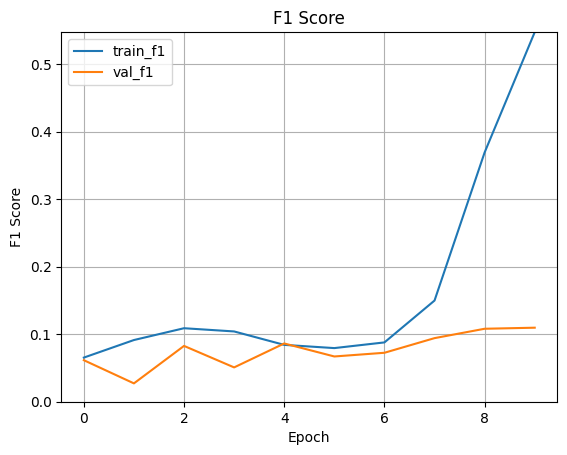

In [41]:
plot_f1(history)

In [42]:
y_pred = cnn_model3.predict([images_mini_v, street_mini_v])
y_pred

53/53 [==============================] - 111s 2s/step


array([[7.11143553e-01, 7.05216452e-03, 2.28156179e-01, ...,
        6.31274481e-04, 1.30220171e-04, 9.15496639e-06],
       [3.69178504e-01, 8.76717716e-02, 3.12732071e-01, ...,
        1.21712370e-03, 2.93481397e-03, 1.26262399e-04],
       [4.91863340e-02, 2.04097614e-01, 2.48682514e-01, ...,
        4.18507057e-04, 1.08931716e-04, 2.20200836e-05],
       ...,
       [1.44839808e-02, 4.45486277e-01, 9.44136456e-02, ...,
        2.12369836e-04, 7.87535537e-05, 2.97503233e-01],
       [3.32857549e-01, 3.12674910e-01, 2.22651988e-01, ...,
        3.03722700e-05, 2.09669495e-04, 3.09733732e-05],
       [4.39223796e-01, 2.03833897e-02, 3.98787290e-01, ...,
        3.62618035e-03, 2.50133289e-05, 2.89040720e-08]], dtype=float32)

In [43]:
pred_values3 = []
for i in y_pred: 
    input_list = i
    max_value = max(input_list)
    index = [index for index, item in enumerate(input_list) if item == max_value]
    pred_values3.append(index[0])
pred_values3[0:5]

[0, 0, 3, 6, 0]

In [44]:
y_true = list(y_val)
y_true[0:5]

[0, 0, 0, 0, 0]

In [45]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, pred_values3)
ind = max(len(np.unique(y_true)), len(np.unique(pred_values3)))
df_cm = pd.DataFrame(cm, index = [i for i in range(ind)],
                  columns = [i for i in range(ind)])
df_cm
#plt.figure(figsize = (10,7))
#sn.heatmap(df_cm, annot=True)

,0,1,2,3,4,5,6,7,8
0,854,129,137,88,30,0,107,0,2
1,1,9,3,9,0,0,4,0,0
2,62,57,36,35,8,0,35,0,0
3,4,21,8,11,2,0,7,0,0
4,0,2,0,0,2,0,0,0,0
5,0,0,0,0,0,0,1,0,0
6,0,5,0,1,1,0,1,0,0
7,0,3,0,0,0,0,0,0,0
8,0,0,0,0,0,0,1,0,0
